# Multiclass Support Vector Machine 연습문제

아래의 노트북 파일의 각 셀에 해당하는 문제의 답을, 외부 파일에 구현해야 하는 코딩까지 포함하여, 도출하시오.

본 연습문제에서 여러분은 다음의 사항을 완수해야 함:
    
- Linear classification의 강의동영상에서 설명드린 Multiclass SVM **loss function**을 계산하는 Python 함수를 구현함. 이때 Numpy를 이용하여 해당 함수를 완전 벡터화된fully-vectorized 방식으로 구현함.
- Multiclass SVM의 fully-vectorized loss function에 대응되는, **analytic gradient**를 계산하는 함수를 구현함. 역시 Numpy를 이용하여 해당 함수를 완전 벡터화된fully-vectorized 방식으로 구현함.
- **numerical gradient**를 계산하는 함수를 함께 구현하여, 앞서 구현한 analytic gradient의 유효성 여부를 **check**함
- Validation set을 이용하여 hyperparameter들, 즉 **learning rate** 및 **regularization strength**의 최적값을 도출함
- **SGD**를 이용하여 구현한 loss function의 **최적화**함
- 학습 결과로 도출된 weight parameter들을 **시각화**함


### 셀1: 본 노트북의 환경 설정을 위한 코드

필요한 패키지 임포트, 그래프plot 크기 설정, 영상 config 설정 등 수행하며, 별도의 코딩 없이 수행만 시키면 됨.

In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 셀2-6: CIFAR-10 Data Loading and Preprocessing

다음 셀들은 모두 데이터 불러오기 및 전처리 등을 수행하며, 역시 별도의 코딩 없이 수행만 시키면 됨.

### 셀2: Data loading

셀2: CIFAR-10 dataset를 파일로부터 읽어온 후, 데이터가 제대로 읽혔는지를 확인하기 위해 dataset이 저장된 변수의 차원을 프린트함.

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### 셀3: Data visualization

셀3: CIFAR-10 dataset의 각 클래스 이름을 변수에 저장하고, 각 클래스별로 랜덤하게 7개의 영상을 이미지로 화면에 표시함.

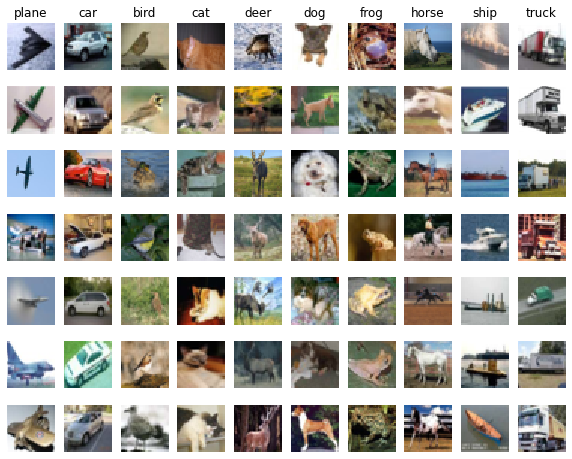

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### 셀4: Dataset partition

전체 학습 dataset을 i) 모델 학습에 사용할 training set, ii) hyperparameter tuning에 사용할 validation set, 그리고 iii) 코딩 과정에서 코드의 유효성을 확인하기 위한 용도인 소량의 development set으로 분할함.

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


### 셀5: Image-to-vector reshaping for all data

모든 데이터를 32x32x3의 3차원 컬러 영상 형식에서 3072의 1차원 벡터 형식으로 변환함.

In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


### 셀6: Data preprocessing

학습 데이터의 평균 벡터를 모든 dataset으로부터 빼 줌으로써 학습 데이터들의 평균을 원점으로 설정하고, 나머지 데이터들은 해당 학습 데이터의 원점을 기준으로 하도록 전처리를 수행함. 아울러 모든 데이터 벡터에 대해 bias parameter에 대응이 되는 차원을 하나 추가하고 해당 차원의 값을 1로 지정함.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]
(3072,)


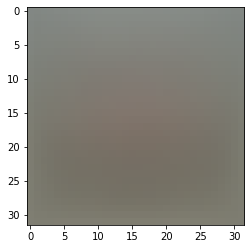

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
print(mean_image.shape)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# bias를 위한 1추가
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## 셀7-10: SVM Classifier

다음 셀들은 Multiclass SVM loss function을 기반으로 하는 linear classification과 관련되며, 여러분이 직접 코드를 구현하여야 함. 이때 모든 코드는 `cs231n/classifiers/linear_svm.py` 파일 내에 구현함. 

### 셀7: SVM loss naive function 호출하여 SVM loss 값 계산

다음 셀에서 확인되듯이, 제공되는 문제 파일들에 이미 loop를 기반으로 multiclass SVM loss function을 계산하는 함수 `svm_loss_naive`는 사전에 구현된 상태로 제공되며, 다음 셀들의 요구 사항을 직접 코드로 구현할 때 참고하도록 함.

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.941661
loss: 8.941661


In [9]:
# from tqdm import tqdm

# #train test
# W = np.random.randn(3073, 10) * 0.0001
# loss_array = []
# for i in tqdm(range (1000)):
#     loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
#     W -= 0.000001 * grad
#     loss_array.append(loss)

# print('loss: %f' % (loss, ))
# plt.plot(loss_array)

In [10]:
# # svm_loss_vectorized
# W = np.random.randn(3073, 10) * 0.0001
# loss_array = []
# for i in tqdm(range (1000)):
#     loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
#     W -= 0.000001 * grad
#     loss_array.append(loss)

# print('loss: %f' % (loss, ))
# plt.plot(loss_array)

### 셀8: SVM loss naive 함수의 gradient 계산 코드 구현

**구현 문제 1**:
위 `svm_loss_naive` 함수에서 반환되는 변수 중 `grad` 값은 모두 0으로 반환됨. 함수 내에 해당 부분에 대한 코드는 구현되지 않고 비어있기 때문임. 따라서 강의동영상에 제시된 **Multiclass SVM loss 함수의 gradient 벡터를 직접 계산하여 도출하고, 이를 코드로 구현**하여 `svm_loss_naive` 함수를 완성하시오. 
이때, `cs231n/classifiers/linear_svm.py` 파일의 `svm_loss_naive` 함수 코드 내의 주석으로도 제시되어 있는 바와 같이, loss 값을 계산하는 이미 구현된 코드에 gradient를 계산하는 코드를 중간중간 삽입하는 방식으로 구현하면 더 편하게 구현할 수 있을 것이니 참고하시오.

구현된 코드가 gradient 벡터 값을 제대로 계산했는지, 유효성을 검증하기 위해, 강의동영상에서 설명한 바와 같이 gradient를 수치적numerically으로도 근사하여 계산할 수 있음. 이를 수행하는 코드는 제공되는 코드의 `cs231n/gradient_check` 파일에 포함되어 있으며, 아래 셀에서는 이를 활용하도록 구현이 되어 있음.

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 25.767495 analytic: 25.767495, relative error: 6.463962e-12
numerical: -10.231728 analytic: -10.231728, relative error: 1.759564e-12
numerical: -7.589406 analytic: -7.589406, relative error: 8.774404e-12
numerical: 8.903376 analytic: 8.903376, relative error: 8.795219e-12
numerical: -2.441975 analytic: -2.441975, relative error: 2.749945e-11
numerical: -11.838398 analytic: -11.838398, relative error: 4.024668e-11
numerical: -0.051221 analytic: -0.051221, relative error: 5.363118e-09
numerical: 34.058492 analytic: 34.058492, relative error: 7.560230e-12
numerical: 18.973880 analytic: 18.973880, relative error: 2.659787e-11
numerical: 3.478678 analytic: 3.478678, relative error: 9.076356e-11
numerical: -3.007615 analytic: -3.007615, relative error: 1.193832e-10
numerical: -8.840751 analytic: -8.840751, relative error: 1.851152e-11
numerical: -17.363400 analytic: -17.363400, relative error: 6.422176e-12
numerical: 14.374399 analytic: 14.374399, relative error: 1.421238e-11
nume

### **서술 문제 1**

Analytic gradient을 잘 계산하고 구현하였다고 하더라도, Multiclass SVM loss 함수는 간혹 가다가 gradcheck로 도출된 gradient와 값이 달라지는 경우가 있을 수 있음. 단일 입력 변수 함수, 즉 1차원 예시에서 이렇게 gradcheck가 실패할 수 있는 경우를 생각해 보고, 어떤 경우에 이런 현상이 발생하는지 서술하시오. 아울러 이런 상황이 우려해야 하는, 즉 classfication 결과 또는 학습에 영향을 주는 상황인지, 아니면 결과적으로는 문제가 되지 않는 상황인지 근거를 들어 설명해 보시오. *Hint: SVM loss function는 엄밀히 미분가능하지 않음*

$\color{blue}{여러분의}$ $\color{blue}{답:}$  
svm loss 같은 경우 max(f,0) 이 존재하기 때문에 미분 불가능한 첨점이 생길 수 밖에없다.  
우리가 구한 기울기는 순간 변화율처럼 보이는 평균 변화율이다.  
근사를 하는것이 아니라 아주 작은 수를 대입하는 것이다.  
현재 값과 아주 작은 수를 더한 값의 평균 변화율을 구하는 것인데, 그사이에 첨점이 존재해버린다면 기울기가 틀어질 수 있다.  
좀 극단적인 경우를 생각한다면 ReLU에서  -1 에서의 순간 기울기는 0이지만  아주 작은 값을 2로 잡으면 순간기울기가 0.5가 된다.  
  
사실 이러한 경우때문에 틀린것이라면, 문제가 없다. 그부분에서만 해석적으로 오류가 나는 것이기 때문이다.  
비선형 함수가 들어있다면, 고려는 해봐야 하는 부분일 것이다.
 

### 셀9: SVM loss vectorized 중 loss 항 계산 코드 구현

**구현 문제 2**: 아래 셀에서 호출되는 함수 `svm_loss_vectorized`의 내부 중 loss 값을 계산하는 부분을 구현하시오. (gradient 계산 부분은 아직 신경 쓰지 않아도 됨) 
이때 Data 변수들이 Numpy의 패키지의 ndarray이기 때문에, Numpy 패키지에 내장된 vectorization 방식의 고속 연산 기능을 활용할 수 있음. 참고로 vectorization 기능을 적절하게 활용할 경우 `svm_loss_naive`에 있었던 이중-for문 loop는 필요가 없어지며, 계산 결과는 `svm_loss_naive`와 동일하게 도출되지만 수행속도는 월등하게 빨라짐.

**참고**: Numpy의 vectorization 기능에 익숙하지 않은 학생은 __[Numpy Tutorial](https://drive.google.com/file/d/19r82cvxCUYKXoDknE0Ig7hV5sGHkLrcR/view?usp=sharing)__을 참고하시오.

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.941661e+00 computed in 0.086338s
Vectorized loss: 8.941661e+00 computed in 0.047609s
difference: 0.000000


### 셀10: SVM loss vectorized 중 gradient 항 계산 코드 구현

**구현 문제 3**: 이제 아래 셀에서 호출되는 함수 `svm_loss_vectorized`의 내부 중 gradient 벡터를 계산하는 부분을 구현하시오. 
역시 vectorization 기능을 적절하게 활용할 경우 `svm_loss_naive`에 있었던 이중-for문 loop는 필요가 없어지며, 계산 결과는 `svm_loss_naive`와 동일하게 도출되지만 수행속도는 월등하게 빨라짐.

In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.087273s
Vectorized loss and gradient: computed in 0.057794s
difference: 0.000000


## 셀11-17: Stochastic Gradient Descent

이제 loss, gradient 계산을 위한 효율적인 vectorized 코드를 구현하였으며, 계산된 gradient 결과는 checkgrad 테스트도 만족함. 이제는 SGD 알고리즘을 이용하여 loss를 최소화하는 linear classifier의 weight parameter를 도출하고자 함. 
이 부분에 대한 여러분의 코드는 `cs231n/classifiers/linear_classifier.py` 파일 내에 구현하면 됨.

### 셀 11: SGD 알고리즘 구현

**구현 문제 4**: 파일 `cs231n/classifiers/linear_classifier.py` 내 LinearClassifier class의 멤버 함수인 LinearClassifier.train() 함수의 구현을 완성하시오. 구현할 부분은 i) 데이터의 랜덤 샘플링을 통해 mini-batch를 생성하는 부분과 ii) 반환된 gradient 벡터를 이용하여 weight parameter 값을 업데이트 하는 두 부분으로 구성됨. 
참고로 해당 파일의 해당 함수 내에 주석에도 대략적인 설명이 되어 있음.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 23.220331
iteration 100 / 1500: loss 7.769462
iteration 200 / 1500: loss 5.415391
iteration 300 / 1500: loss 4.939272
iteration 400 / 1500: loss 5.257209
iteration 500 / 1500: loss 4.792496
iteration 600 / 1500: loss 4.635793
iteration 700 / 1500: loss 5.203910
iteration 800 / 1500: loss 4.855700
iteration 900 / 1500: loss 4.733609
iteration 1000 / 1500: loss 5.161139
iteration 1100 / 1500: loss 4.637351
iteration 1200 / 1500: loss 4.557981
iteration 1300 / 1500: loss 4.722648
iteration 1400 / 1500: loss 4.483009
That took 31.604101s


### 셀 12: 학습 과정의 loss 값 시각화

아래의 셀은 위의 multiclass SVM loss를 기반으로 하는 linear classifier를 학습하는 과정에서의 loss 값들을 그래프로 표시한 것으로, loss 값이 적절하게 감소하였는지를 확인하게 해 주어 이를 토대로 SGD 알고리즘이 제대로 구현되었는지를 체크할 수 있게 함.

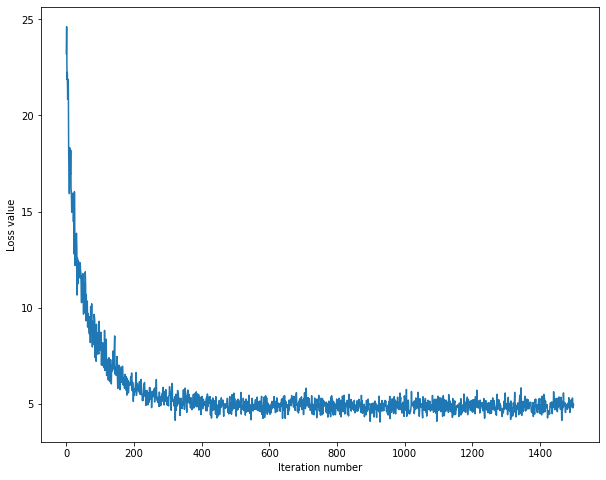

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 셀 13: 학습된 linear classifier를 이용한 분류값 predict 함수 구현

**구현 문제 5**: 파일 cs231n/classifiers/linear_classifier.py 내 LinearClassifier class의 멤버 함수인 LinearClassifier.predict() 함수의 구현을 완성하시오. 구현할 부분은 학습 후 저장된 weight parameter들을 이용하여 linear classifier의 출력값을 계산하는 부분임. 해당 파일의 해당 함수 내의 주석으로 결과 값을 저장할 변수를 안내함.

In [16]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368306
validation accuracy: 0.387000


### 셀 14: Hyperparameter tuning

**구현 문제 6**: 앞서 분할해 놓은 validation dataset을 이용하여 아래 셀에 learning rate 및 regularization 가중치 등 hyperparameter를 최적화하는 코드를 구현하시오. 상세한 내용은 아래 코드의 주석을 확인하시오.

In [34]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 5e-8, 1e-7]
regularization_strengths = [5e3, 2.5e4]
iters = 1500
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        #train
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=learning_rates[i], reg=regularization_strengths[j],num_iters=iters, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)

        # save data
        results[(learning_rates[i], regularization_strengths[j])] = (training_accuracy, validation_accuracy)

        # if best
        if best_val < validation_accuracy:
            best_val = validation_accuracy
            best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.234898 val accuracy: 0.210000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.252816 val accuracy: 0.254000
lr 5.000000e-08 reg 5.000000e+03 train accuracy: 0.319020 val accuracy: 0.322000
lr 5.000000e-08 reg 2.500000e+04 train accuracy: 0.371694 val accuracy: 0.383000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.372694 val accuracy: 0.372000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370469 val accuracy: 0.367000
best validation accuracy achieved during cross-validation: 0.383000


### 셀 15: training set 및 validation set에 대한 hyperparameter 추세 시각화

아래 셀에서는 위 셀에서 수행한 hyperparameter tuning 과정에서 계산된 각 hyperparameter의 값 별로 training 및 validation dataset에 대해 도출되는 정확도를 그래프로 시각화하여 줌. 

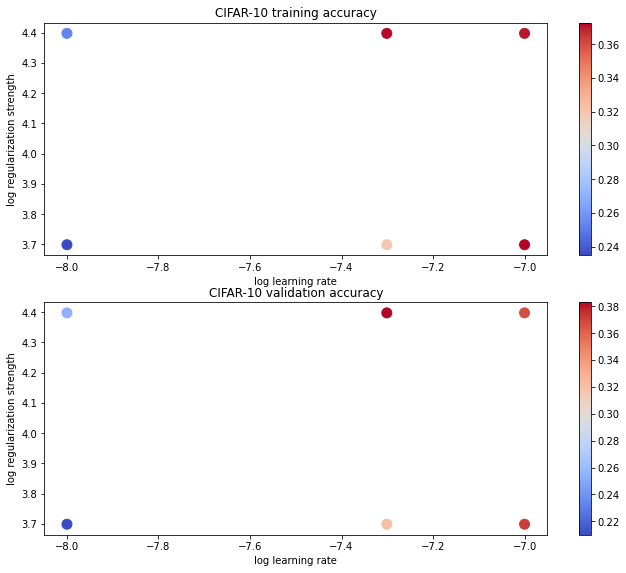

In [36]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

### 셀 16: test set에 대한 성능 확인

학습된 multiclass svm loss 기반의 linear classifier의 정확도를 test dataset에 대해서 측정하여 제시함.

In [37]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


### 셀 17: 학습된 class 별 weight parameter 시각화

아래 셀에서는 강의03 강의동영상(슬라이드 36번)에서 설명되었던 linear classifier의 시각적 이해 관점에서, 학습된 multiclass svm loss 기반의 linear classifier의 class별 weight vector를 이미지로 시각화하여 제시함.

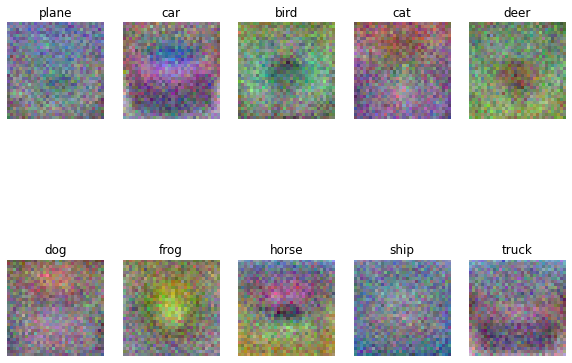

In [38]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### **서술 문제 2**

시각화된 linear classifier들의 weight vector들이 무엇으로 보이는지, 왜 그렇게 보이는지 간단하게 제시하시오.

$\color{blue}{여러분의}$ $\color{blue}{답:}$  
train 하는 과정을 크게 보면 대상이미지와 먼저 10개의 class의 weight과 픽셀 단위로 내적을 하게 됩니다.  
둘을 내적한 값은 이미지와 weight와 시각적으로 얼마나 유사한지를 나타낸다고 할 수 있습니다.  
학습 과정을 통해서 많은 각각의 클래스 의 특징들을 반영하고, 자신과 다른 클래스와 비슷한 특징들을 빼내면서 Weight 들을 학습해 나갔습니다.  
그래서 완전히 각각의 클래스에 대한 사진들이 약간 noise 하지만, 각 클래스를 나타내는 사진처럼 보이게 되는 것 같습니다  